## Part 8: Uplift Modelling
Notes from this notebook comes from various resources listed at the end of the notebook. This will be good exposure to using more plotly to produce interactable plots vs. matplotlib as well predictive modeling.

-------

### Areas of Focus

- Uplift modelling
    - Used to make campaigns more efficient by:
        - Targeting specific segments based on uplift score
        - Try different offers based on customer's uplift score
    - Uplift Score = P(tr) + P(cn) - P(tn) - P(cr)

### Business Problem

Segmentation helps growth hackers increase conversion and be cost-efficient and maximize return for a given budget/time/effort constraint. 

What if you're about to launch a promotional campaign and you know which segment you want to target? Do you need to send everyone the offer? We definitely don't. Just like using RFM segmentation, groups vary and each can have a separate action that will be more efficient than another. 

In the current target group, there will be customers who are going to purchase anyways. Why waste budget on that group? We shouldn't and that's what scoring is about. One way is to identify the segments based on a grouping approach like below:

- Treatment responders: customers that will purchase only if they receive an offer

- Treatment non-responders: customers that won't purchase in any case

- Control responders: customers that will purchase without an offer

- Control non-responders: customers that will not purchase if they don't receive an offer

With the information above, we can see the differences between the groups. We want to have as much responder type customers (besides responders that will buy with or without an offer). So what we need to do is create strategies revolving around the groups with the highest chance of conversion, which are Treatment Responders (TR) and Control Non-Responders (CN).

### Results

### Data

- recency: months since last purchase
- history: $value of the historical purchases
- used_discount/used_bogo: indicates if the customer used a discount or buy one get one before
- zip_code: class of the zip code as Suburban/Urban/Rural
- is_new: indicates if the customer new
- channel: channels that the customer using, Phone/Web/Multichannel
- offer: the offers sent to the customers, Discount/But One Get One/No Offer

### Process

### Libraries

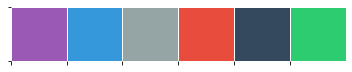

In [1]:
# Toolbox 101
from datetime import datetime, timedelta, date
import pandas as pd
import pandas_profiling
import numpy as np
import random as rand
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import plotly.plotly as py
import plotly.graph_objs as go # graph_objects in version 4 (currently have plotly v3 installed)
import plotly.offline as pyoff

# Stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats

# Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBRegressor, XGBClassifier, plot_importance, plot_tree

# Evaluation
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

# Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 5000
pd.options.display.max_rows = 5000

# Set palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
#34495e

seed = 100

### Helpers

In [2]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    if len(all_nulls) > 8:
        plt.figure(figsize=(12, 8))
    elif len(all_nulls) > 5:
        plt.figure(figsize=(6, 8))
    else:
        plt.figure(figsize=(4, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.ylim(0, 100)
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()
    
# Create a new function to capture feature importance for models
def feature_importance(model):
    
    importance = pd.DataFrame({'Feature': headers,
                               'Importance': np.round(model.feature_importances_,3)})
    
    importance = importance.sort_values(by = 'Importance', ascending = False).set_index('Feature')
    
    return importance

# Order clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    '''Add new score to the data'''
    
    # Create a new field name
    new_cluster_field_name = 'new_' + cluster_field_name
    # Group up the recency scores
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    # Merge the dataframes
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={'index': cluster_field_name})
    return df_final

# Define uplift formula
def calc_uplift(data):
    # Assign $25 to the average order value
    avg_order_val = 25
    
    # Calculate conversion for each offer type
    base_conv = data[data.offer=='No Offer']['conversion'].mean()
    disc_conv = data[data.offer=='Discount']['conversion'].mean()
    bogo_conv = data[data.offer=='Buy One Get One']['conversion'].mean()
    
    # Calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    # Calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(data[data.offer=='Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(data[data.offer=='Buy One Get One']['conversion'])
    
    # Calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_val
    bogo_rev_uplift = bogo_order_uplift * avg_order_val
    
    # Print results
    print('-------------- \n')
    print('Uplifts Compared to Control')
    print('-------------- \n')
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100, 2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift, 2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift, 2)))
    print('-------------- \n')
    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100, 2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift, 2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift, 2)))
    

### Data

In [3]:
# Import data
data = pd.read_csv('LargeData/29-data.csv')

In [4]:
data.shape

(64000, 9)

In [5]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_new,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [6]:
data.describe()

,recency,history,used_discount,used_bogo,is_new,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


Frequency of conversion :


,Count,Percentage
0,54606,85.32
1,9394,14.68


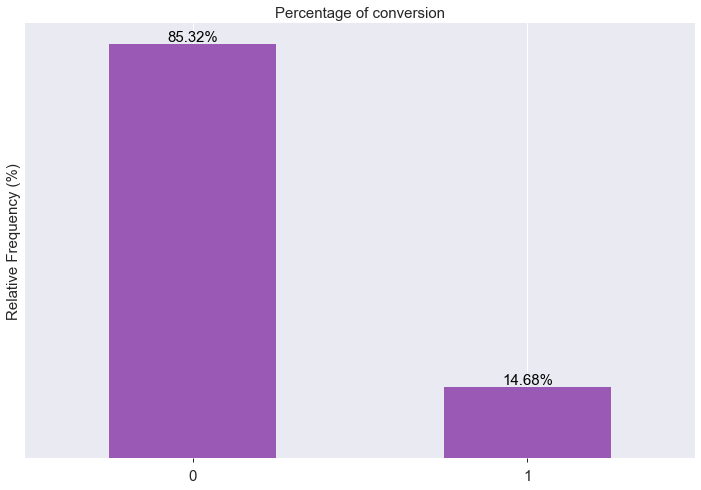

In [7]:
freq_table(data.conversion)

In [8]:
64000*.1468

9395.2

There are only 9,395 converted customers from the dataset of 64,000.

In [9]:
get_nulls(data)

There are 0 columns with missing values.


,Null Data Count,Null Data Pct


There are no missing values in the dataset.

### Check uplift numbers used in this campaign

One way to measure how good of a campaign it is is to use a benchmark. The benchmark will allow us to compare the results of what we are trying implement (new strategy) to get more revenue and customers. If the model/strategy is not working, it will show in the numbers. At times, there can be situations where we may not have enough power to determine if it's statistically significant in our tests, so we have to use domain knowledge to make the decision. If there is a positive/correct trend going in the right direction, I would want to say let's move with this strategy. Not every plan will work and that's why why we doing trials until we have a solid result.

In [10]:
calc_uplift(data)

-------------- 

Uplifts Compared to Control
-------------- 

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


Remember that we made an assumption that an average order value is $25. Using that number, we calculate the base, discount, and bogo conversions and conversion uplifts against the base conversion. From there, we calculate the order uplift to use in our revenue uplift formula.

The results above indicate a conversion uplift of 7.66 percent for discount and a 4.52 percent for bogo. This totals to approximately $65K in revenue uplift if we use the offers.

### Modelling

Create a multi-classification model for predicting the uplift score. Remember that we have labels on whether the customer converted or not. We need to identify four new responder classes (TR, TN, CR, CN) to better devise a more efficient strategy.

#### What do we currently know? 
We know that the customers who received discount and bogo offers are Treatment and the rest is control. Treatment is the group that we have examined and received a "treatment" (offers) while control is the group that did not receive any experimental manipulation (base).

### Create a new feature to identify treatment and control groups

In [11]:
# Treatment group
data['campaign_group'] = 'treatment'

# Control group
data.loc[data.offer=='No Offer', 'campaign_group'] = 'control'

Frequency of campaign_group :


,Count,Percentage
treatment,42694,66.71
control,21306,33.29


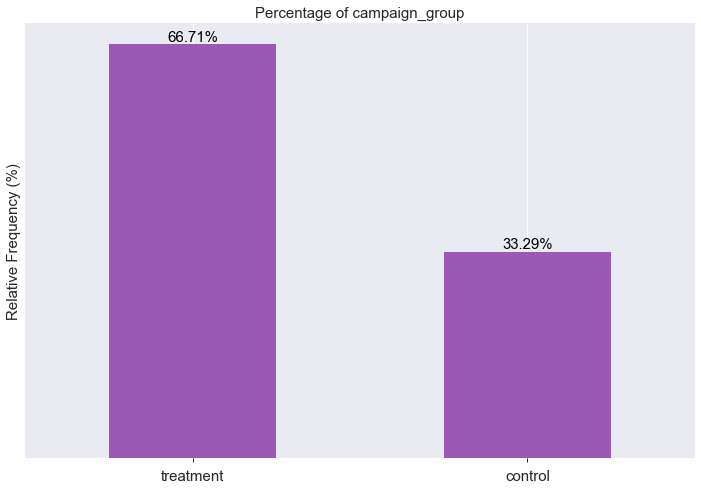

In [12]:
freq_table(data.campaign_group)

33% of the customers have not used an offer. As expected, majority of the customers used a type of offer. I mean, why wouldn't you?

### Create a new feature to identify the responder labels

In [13]:
# CN: Control non-responders
data['target_class'] = 0

# CR: Control responders
data.loc[(data.campaign_group=='control') & (data.conversion==1)] = 1

# TN: Treatment non-responders
data.loc[(data.campaign_group=='treatment') & (data.conversion==0)] = 2

# TR: Treatment responders
data.loc[(data.campaign_group=='treatment') & (data.conversion==1)] = 3

Frequency of target_class :


,Count,Percentage
2,35562,55.57
0,19044,29.76
3,7132,11.14
1,2262,3.53


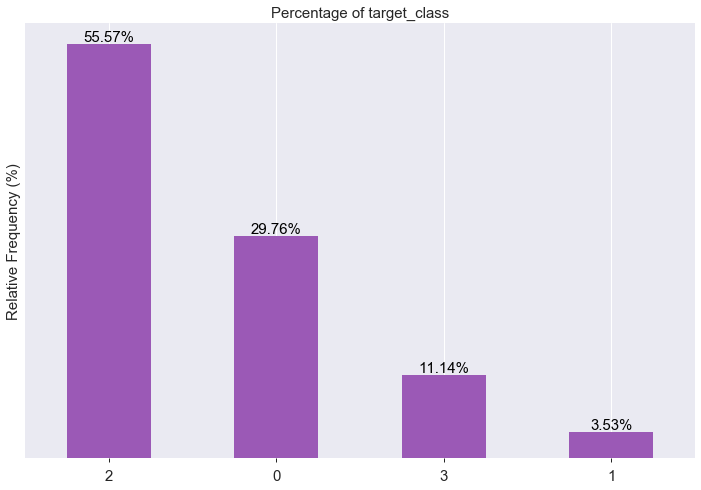

In [14]:
freq_table(data.target_class)

### Target proportion

#### Did not convert
- 2 TN: Treatment non-responders (55.6%)
- 0 CN: Control non-responders (29.8%)

#### Converted
- 3 TR: Treatment responders (11.1%)
- 1 CR: Control responders (3.5%)

### Create history cluster features

- Create clusters from the history feature using Kmeans
- Order the clusters with our function

In [15]:
# Create history clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(data[['history']])

# Predict cluster
data['history_cluster'] = kmeans.predict(data[['history']])

# Order
data = order_cluster('history_cluster', 'history', data, True)

### Drop features not used for the model

In [16]:
train = data.drop(['offer', 'campaign_group', 'conversion'], axis=1)

# Convert all categorical features 
train = pd.get_dummies(train)

In [17]:
train.head()

,recency,history,used_discount,used_bogo,is_new,target_class,history_cluster,zip_code_1,zip_code_2,zip_code_3,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_1,channel_2,channel_3,channel_Multichannel,channel_Phone,channel_Web
0,2,2.0,2,2,2,2,0,0,1,0,0,0,0,0,1,0,0,0,0
1,2,2.0,2,2,2,2,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,2.0,2,2,2,2,0,0,1,0,0,0,0,0,1,0,0,0,0
3,2,2.0,2,2,2,2,0,0,1,0,0,0,0,0,1,0,0,0,0
4,3,3.0,3,3,3,3,0,0,0,1,0,0,0,0,0,1,0,0,0


In [18]:
train.shape

(64000, 19)

### Split X & y

In [19]:
y = train.target_class
X = train.drop(['target_class'], axis=1)

### Split into train and test sets

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

### Initial XGB model

In [21]:
# Fit the model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [22]:
# Predict probabilities
class_prob = xgb_model.predict_proba(X_test)

In [23]:
# Check
class_prob[0]

array([9.9991298e-01, 3.6617086e-05, 2.6741898e-05, 2.3625629e-05],
      dtype=float32)

The probabilities for this customer is extremely low. I am wondering if it's like this for many of the customers.

In [24]:
class_prob[1]

array([3.0268686e-05, 2.9619727e-05, 3.2970795e-05, 9.9990714e-01],
      dtype=float32)

It looks like the probabilities aren't spread across the categories. It's 99% on a single class each time.
- Example 1: 0.00 + 0.00 + 0.99 + 0.00 = 0.10
- Example 2: 0.00 + 0.00 + 0.00 + 0.99 = 0.10

### Apply the model to the original dataset

In [25]:
final_data = data.copy()

In [26]:
# Probabilities for all customers
overall_prob = xgb_model.predict_proba(train.drop(['target_class'], axis=1))

In [27]:
overall_prob[100]

array([2.2636184e-05, 2.2150865e-05, 9.9993348e-01, 2.1783608e-05],
      dtype=float32)

In [28]:
# Assign probabilities
train['prob_CN'] = overall_prob[:,0] 
train['prob_CR'] = overall_prob[:,1] 
train['prob_TN'] = overall_prob[:,2] 
train['prob_TR'] = overall_prob[:,3]

In [29]:
# Calculate uplift score
train['uplift_score'] = train['prob_CN'] + train['prob_TR'] - train['prob_CR'] + train['prob_TN']

In [30]:
train.head()

,recency,history,used_discount,used_bogo,is_new,target_class,history_cluster,zip_code_1,zip_code_2,zip_code_3,...,channel_2,channel_3,channel_Multichannel,channel_Phone,channel_Web,prob_CN,prob_CR,prob_TN,prob_TR,uplift_score
0,2,2.0,2,2,2,2,0,0,1,0,...,1,0,0,0,0,0.000023,0.000022,0.999933,0.000022,0.999956
1,2,2.0,2,2,2,2,0,0,1,0,...,1,0,0,0,0,0.000023,0.000022,0.999933,0.000022,0.999956
2,2,2.0,2,2,2,2,0,0,1,0,...,1,0,0,0,0,0.000023,0.000022,0.999933,0.000022,0.999956
3,2,2.0,2,2,2,2,0,0,1,0,...,1,0,0,0,0,0.000023,0.000022,0.999933,0.000022,0.999956
4,3,3.0,3,3,3,3,0,0,0,1,...,0,1,0,0,0,0.000030,0.000030,0.000033,0.999907,0.999941
